In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from lightgbm import LGBMClassifier
from lightgbm import plot_importance as lgbm_plot_importance
from xgboost import XGBClassifier
from xgboost import plot_importance as xgb_plot_importance

/Users/hannahan/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# feature engineering 및 모델별 성능 확인

### 평가 지표 함수

In [2]:
def eval_metrics(y_test, title='Confusion Matrix', pred=None, pred_proba=None):
    cm = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    
    label_names = ['TN', 'FP', 'FN', 'TP']
    counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{ln}\n{c}\n{p}" for ln, c, p in zip(label_names, counts, percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues').set(title=title)
    plt.show()
    
    print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f}, f1: {3:.4f}, roc_auc: {4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))
    
    scores_dict = {
        'accuracy': accuracy,
        'precision': precision, 
        'recall': recall, 
        'f1': f1, 
        'roc_auc': roc_auc
    }
    return scores_dict

# 0. 별다른 feature engineering 없이 진행

In [3]:
train_a = pd.read_csv('../data/osa_train_a.csv')
train_a.head()

,ID,sex,age,height,weight,BMI,Time in Bed(min),Total sleep time(min),Sleep latency(min),N2 sleep latency(min),...,ODI,90%ODI,EtCO2 (>50mmHg),Total LMI =PLMI(/h),Total LM Arousal#,Total LM AI(/h),PLM Arousal#,PLM AI(/h),MAI(/h),OSA
0,2170,0,38,173.0,88.0,29.4,448.9,434.5,5.5,4.0,...,62.6,47.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,3539,1,54,156.0,49.0,20.1,476.0,426.0,3.0,2.5,...,2.4,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,108,0,62,164.0,67.0,24.9,435.5,351.0,3.5,1.0,...,7.4,0.3,0.0,16.8,9.0,1.5,0.0,0.0,1.5,1
3,3149,0,33,175.0,106.0,34.6,404.5,374.5,7.0,3.5,...,19.2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,4893,0,56,164.0,72.0,26.8,359.5,236.5,12.5,11.0,...,70.5,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [4]:
test_a = pd.read_csv('../data/osa_test_a.csv')
test_a.head()

,ID,sex,age,height,weight,BMI,Time in Bed(min),Total sleep time(min),Sleep latency(min),N2 sleep latency(min),...,ODI,90%ODI,EtCO2 (>50mmHg),Total LMI =PLMI(/h),Total LM Arousal#,Total LM AI(/h),PLM Arousal#,PLM AI(/h),MAI(/h),OSA
0,2021,1,47,164.0,55.0,20.4,362.0,343.0,5.5,2.0,...,7.5,1.0,0.0,11.4,5.0,0.9,5.0,0.9,1.8,1
1,1506,0,64,175.0,75.0,24.5,395.0,342.0,5.0,4.5,...,9.5,0.4,0.0,0.4,2.0,0.4,0.0,0.0,0.4,0
2,3160,0,34,170.0,79.0,27.3,415.0,363.5,7.5,20.5,...,5.3,0.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,1092,0,66,167.0,68.0,24.4,318.0,104.0,21.0,6.5,...,67.5,31.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,5043,0,60,169.0,67.0,23.5,383.0,310.0,6.5,4.0,...,31.5,2.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [5]:
X_train_a = train_a.drop(['ID', 'OSA'], axis=1)
y_train_a = train_a['OSA']

In [6]:
X_test_a = test_a.drop(['ID', 'OSA'], axis=1)
y_test_a = test_a['OSA']

In [7]:
features_a = list(X_train_a.columns)
train = X_train_a.copy()
test = X_test_a.copy()

scaler = MinMaxScaler(feature_range=(0,1))

scaler.fit(train)
train_a = scaler.transform(train)
test_a = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (4121, 77)
Testing data shape:  (1031, 77)


In [8]:
train_b = pd.read_csv('../data/osa_train_b.csv')
train_b.head()

,ID,sex,age,height,weight,BMI,Time in Bed(min),Total sleep time(min),Sleep latency(min),REM sleep latency(min),...,Lateral A+H+RERA_ Index(h),REM A+H+RERA Index(/h),NREM A+H+RERA Index(/h),Apnea_Max_ Length(sec),Hypopnea_Max_ Length(sec),Resp. Arousal /(A+H)(%),ODI,90%ODI,EtCO2 (>50mmHg),OSA
0,4238,0,39,170.0,65.0,22.5,480.5,435.0,2.5,63.0,...,4.2,11.6,8.2,0.0,69.2,87.9,2.3,0.0,0.0,1
1,1630,0,41,172.0,77.0,26.0,338.5,187.0,3.0,86.5,...,0.0,41.7,19.8,83.4,101.6,38.2,23.7,5.5,0.0,1
2,2711,0,64,166.0,69.0,25.0,450.0,376.0,8.0,62.0,...,20.7,54.1,42.5,57.4,112.9,79.9,31.9,8.3,0.0,1
3,662,1,58,157.0,56.0,22.7,394.0,371.0,1.0,188.5,...,0.0,51.9,32.1,47.0,62.7,19.2,33.0,8.1,0.0,1
4,4666,1,29,154.0,50.0,21.1,278.0,252.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [10]:
test_b = pd.read_csv('../data/osa_test_b.csv')
test_b.head()

,ID,sex,age,height,weight,BMI,Time in Bed(min),Total sleep time(min),Sleep latency(min),REM sleep latency(min),...,Lateral A+H+RERA_ Index(h),REM A+H+RERA Index(/h),NREM A+H+RERA Index(/h),Apnea_Max_ Length(sec),Hypopnea_Max_ Length(sec),Resp. Arousal /(A+H)(%),ODI,90%ODI,EtCO2 (>50mmHg),OSA
0,3402,1,35,164.0,56.0,20.8,486.5,452.0,11.0,41.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,4990,0,41,175.0,92.0,30.0,510.0,492.5,5.0,91.0,...,6.3,16.2,6.6,0.0,79.2,63.6,7.1,0.0,0.0,1
2,2171,0,54,169.0,82.0,28.7,416.0,312.5,7.0,109.5,...,45.3,50.7,73.2,49.7,65.6,83.8,58.0,30.3,0.0,1
3,508,0,45,180.0,76.0,23.5,375.0,342.5,4.0,132.5,...,0.0,34.0,5.1,24.5,67.6,62.3,4.4,0.7,0.0,1
4,3448,0,47,174.0,110.0,36.3,222.0,171.0,4.5,62.0,...,108.5,78.7,119.1,52.2,48.5,69.6,112.6,101.1,0.0,1


In [11]:
X_train_b = train_b.drop(['ID', 'OSA'], axis=1)
y_train_b = train_b['OSA']

In [12]:
X_test_b = test_b.drop(['ID', 'OSA'], axis=1)
y_test_b = test_b['OSA']

In [13]:
features_b = list(X_train_b.columns)
train = X_train_b.copy()
test = X_test_b.copy()

scaler = MinMaxScaler(feature_range=(0,1))

scaler.fit(train)
train_b = scaler.transform(train)
test_b = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (4347, 61)
Testing data shape:  (1087, 61)


## 0-3. Random Forest

### A. with osa_data_a

In [14]:
params_dict = {
    'n_estimators': [10, 50, 100],
    'max_depth': [2, 4, 6, 8, 10, 12],
    'min_samples_leaf': [2, 4, 6, 8, 12, 18],
    'min_samples_split': [2, 4, 6, 8, 16, 20]
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), params_dict, cv=3, refit=True)
grid_rf.fit(train_a, y_train_a)

print(grid_rf.best_params_)
print(grid_rf.best_score_)

{'max_depth': 8, 'min_samples_leaf': 6, 'min_samples_split': 20, 'n_estimators': 10}
0.9153113363604527


In [15]:
y_pred_proba = grid_rf.best_estimator_.predict_proba(test_a)[:,1]
y_pred = (y_pred_proba > 0.5).astype(int)
y_pred

array([1, 1, 1, ..., 0, 1, 1])

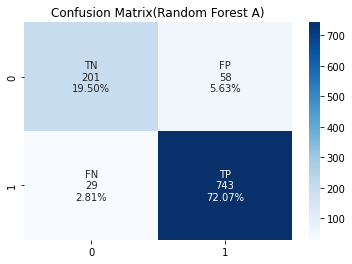

accuracy: 0.9156, precision: 0.9276, recall: 0.9624, f1: 0.9447, roc_auc: 0.9658


In [16]:
scores = eval_metrics(y_test_a, title="Confusion Matrix(Random Forest A)", pred=y_pred, pred_proba=y_pred_proba)

In [17]:
forest = grid_rf.best_estimator_
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

In [18]:
# based on MDI
forest_importances = pd.Series(importances, index=features_a)
forest_importances

sex                  0.000147
age                  0.001273
height               0.006693
weight               0.007649
BMI                  0.003549
                       ...   
Total LM Arousal#    0.003164
Total LM AI(/h)      0.001737
PLM Arousal#         0.001013
PLM AI(/h)           0.003405
MAI(/h)              0.001052
Length: 77, dtype: float64

In [19]:
# based on feature permutation
permut_importance = permutation_importance(
    forest, test_a, y_test_a, n_repeats=10, random_state=42, n_jobs=2
)
forest_importances = pd.Series(permut_importance.importances_mean, index=features_a)
forest_importances

sex                  0.000000e+00
age                  1.163919e-03
height              -1.260912e-03
weight              -2.424830e-03
BMI                 -1.454898e-03
                         ...     
Total LM Arousal#    1.110223e-17
Total LM AI(/h)     -8.729389e-04
PLM Arousal#         0.000000e+00
PLM AI(/h)          -7.759457e-04
MAI(/h)              9.699321e-04
Length: 77, dtype: float64

In [20]:
forest_importances.nlargest(n=10)

Total_A+H+RERA_ Index(/h)    0.007177
Total A+H #                  0.006111
REM A+H+RERA Index(/h)       0.003201
NREM A+H Index(/h)           0.002328
Supine_Apnea_ Index(/h)      0.002134
Snore Arousal #              0.001358
Resp. Arousal /(A+H)(%)      0.001358
Supine Arousal index(h)      0.001261
Sleep latency(min)           0.001261
age                          0.001164
dtype: float64

In [21]:
mdi_importances = pd.Series(importances, index=features_a)
mdi_importances.nlargest(n=10)

Total_A+H+RERA_ Index(/h)    0.186254
SUPINE A+H Index(/h)         0.142423
Total A+H #                  0.118894
Total Hypopnea Index(h)      0.077470
NREM A+H Index(/h)           0.077230
Total- A+H+RERA#             0.043790
Supine0 A+H+RERA_Index(h)    0.039270
Apnea_Max_ Length(sec)       0.038548
Total_Apnea_ Index(/h)       0.028402
Total_ apnea #               0.027355
dtype: float64

### B. with osa_data_b

In [22]:
grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), params_dict, cv=3, refit=True)
grid_rf.fit(train_b, y_train_b)

print(grid_rf.best_params_)
print(grid_rf.best_score_)

{'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 16, 'n_estimators': 50}
0.9155739590522199


In [23]:
y_pred_proba = grid_rf.best_estimator_.predict_proba(test_b)[:,1]
y_pred = (y_pred_proba > 0.5).astype(int)
y_pred

array([0, 1, 1, ..., 1, 1, 1])

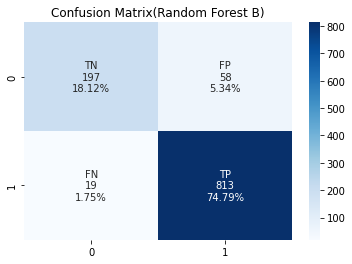

accuracy: 0.9292, precision: 0.9334, recall: 0.9772, f1: 0.9548, roc_auc: 0.9751


In [24]:
scores = eval_metrics(y_test_b, title="Confusion Matrix(Random Forest B)", pred=y_pred, pred_proba=y_pred_proba)

In [25]:
forest = grid_rf.best_estimator_
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

In [26]:
# based on MDI
forest_importances = pd.Series(importances, index=features_b)
forest_importances

sex                          0.001515
age                          0.005132
height                       0.005254
weight                       0.007440
BMI                          0.003764
                               ...   
Hypopnea_Max_ Length(sec)    0.003437
Resp. Arousal /(A+H)(%)      0.002464
ODI                          0.016556
90%ODI                       0.011989
EtCO2 (>50mmHg)              0.000000
Length: 61, dtype: float64

In [27]:
# based on feature permutation
permut_importance = permutation_importance(
    forest, test_b, y_test_b, n_repeats=10, random_state=42, n_jobs=2
)
forest_importances = pd.Series(permut_importance.importances_mean, index=features_b)
forest_importances

sex                          0.002024
age                          0.001380
height                       0.001472
weight                       0.001656
BMI                          0.000920
                               ...   
Hypopnea_Max_ Length(sec)    0.002852
Resp. Arousal /(A+H)(%)      0.000460
ODI                          0.001104
90%ODI                       0.001380
EtCO2 (>50mmHg)              0.000000
Length: 61, dtype: float64

In [28]:
forest_importances.nlargest(n=10)

Total Hypopnea Index(h)         0.005060
NREM A+H+RERA Index(/h)         0.004692
Total- A+H+RERA#                0.004600
sleep efficiency(%)             0.004232
SUPINE A+H Index(/h)            0.003680
Respiratory Aroual index(/h)    0.003404
Movement Aroual index(/h)       0.003220
Total A+H Index(/h)             0.003220
REM sleep latency(min)          0.003220
Obstructive apnea #             0.003128
dtype: float64

In [29]:
mdi_importances = pd.Series(importances, index=features_b)
mdi_importances.nlargest(n=10)

Total A+H Index(/h)             0.173766
Total A+H #                     0.101029
Total_A+H+RERA_ Index(/h)       0.073978
SUPINE A+H Index(/h)            0.073844
Respiratory Aroual index(/h)    0.071765
Total- A+H+RERA#                0.068109
Respriratory Arousal #          0.063950
Supine0 A+H+RERA_Index(h)       0.046465
Total Hypopnea Index(h)         0.035502
Obstructive apnea #             0.033456
dtype: float64